#### Load Google news vectors for word mover distance comparison from actual and generated headline

In [1]:
from gensim.models.keyedvectors import KeyedVectors
goo_word2vec_model = KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)
#!pip install pyemd

Using TensorFlow backend.


In [2]:
def calc_wm_distance(tokens1, tokens2):   
    goo_word2vec_model.init_sims(replace=True) # normalizes vectors
    distance = goo_word2vec_model.wmdistance(tokens1, tokens2)
    return distance

#### Function to generate headlines for test case including random article not in original dataset

In [3]:
import pickle
import random

def generate_test_preds(random_test_cases=True, live_demo=False, head=None, desc=None, idx=None):    
    FN0 = 'tokens'
    with open('data/%s.pkl'%FN0, 'rb') as fp:
        headlines, bodies, keys = pickle.load(fp)
        articles = [headlines[i] + "." + bodies[i] for i in range(len(headlines))]
        actual_generated = []
        #from nltk.stem.porter import PorterStemmer
        #porter_stemmer = PorterStemmer()           
        #titles = [porter_stemmer.stem(w) for w in titles]        
        from gensim.summarization import keywords
        if live_demo:
            idx = [0]
            articles = [head.lower() + "." + desc.lower() if head else desc.lower()]     
            headlines = [head]
        elif random_test_cases: 
            if len(idx) == 0:
                idx = list(set([random.randint(0, 281) for i in range(10)]))
        else:
            idx = list(range(len(articles)))
            
        for i in idx: 
            try:
                titles = keywords(articles[i], ratio=0.5, lemmatize=True).replace("\n", " ").split(" ")
            except:
                titles = []

           
            titles = sorted(set(titles), key=titles.index)
            if len(titles) >= 4:
                num = random.randint(5,14)
                gen = titles[:num]                
                actual_generated.append([i, headlines[i].lower(),(" ").join(gen)])                 
    return actual_generated

#### Function to return the output as a dataframe

In [4]:
import pandas as pd
def convert_df(datatlist):
    df = pd.DataFrame(datatlist)
    df.columns = ['index', 'actual', 'generated']
    return df

#### Generate headlines for all articles in the original dataset

In [11]:
import time
start = time.time()
tc_all = generate_test_preds(random_test_cases=False)
tc_all_df = convert_df(tc_all)
print("Time:",time.time()-start)

Time: 27.7809100151062


#### Test for random article not in original dataset - Demo case

In [13]:
start = time.time()
head = "THE EIGHT PARTS OF SPEECH"
desc = "A noun is a word for a person, place, thing, or idea. Nouns are often used with an article (the, a, an), but not always. Proper nouns always start with a capital letter; common nouns do not. Nouns can be singular or plural, concrete or abstract. Nouns show possession by adding 's. Nouns can function in different roles within a sentence; for example, a noun can be a subject, direct object, indirect object, subject complement, or object of a preposition."
preds = generate_test_preds(live_demo=True, head=head, desc=desc)
print("Actual:", preds[0][1])
print("Generated:", preds[0][2])
print("Word Mover Distance:", calc_wm_distance(preds[0][1].split(" "), preds[0][2].split(" ")))
print("Time:",time.time()-start)

Actual: the eight parts of speech
Generated: nouns place subject object letter common plural concrete
Word Mover Distance: 1.2721394595587252
Time: 19.13753914833069


#### Find word mover distance for all generated headlines for the original dataset

In [16]:
start = time.time()
tc_all_df['wm_distance'] = tc_all_df.apply(lambda row: calc_wm_distance(row['actual'].split(" "),row['generated'].split(" ")),axis=1)
print("Time:",time.time()-start)

Time: 5901.027435064316


#### Store actual and generated headlines with word mover distance for all articles in the original dataset

In [18]:
tc_all_df.to_csv("data/preds/model2_preds_all.csv")

#### Plot embedding vector (T-SNE)

In [19]:
import sys
import codecs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
 
 
def plot_emb_vec(embeddings_file, num_words=500):
 
    #embeddings_file = sys.argv[1]
    wv, vocabulary = load_embeddings(embeddings_file)
 
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(wv[:num_words,:])
    plt.figure(figsize=(40, 40), dpi=100)
    plt.scatter(Y[:, 0], Y[:, 1])
    for label, x, y in zip(vocabulary, Y[:, 0], Y[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.show()
 
 
def load_embeddings(file_name):
 
    with codecs.open(file_name, 'r', 'utf-8') as f_in:
        vocabulary, wv = zip(*[line.strip().split(' ', 1) for line in 
f_in])
    wv = np.loadtxt(wv)
    return wv, vocabulary

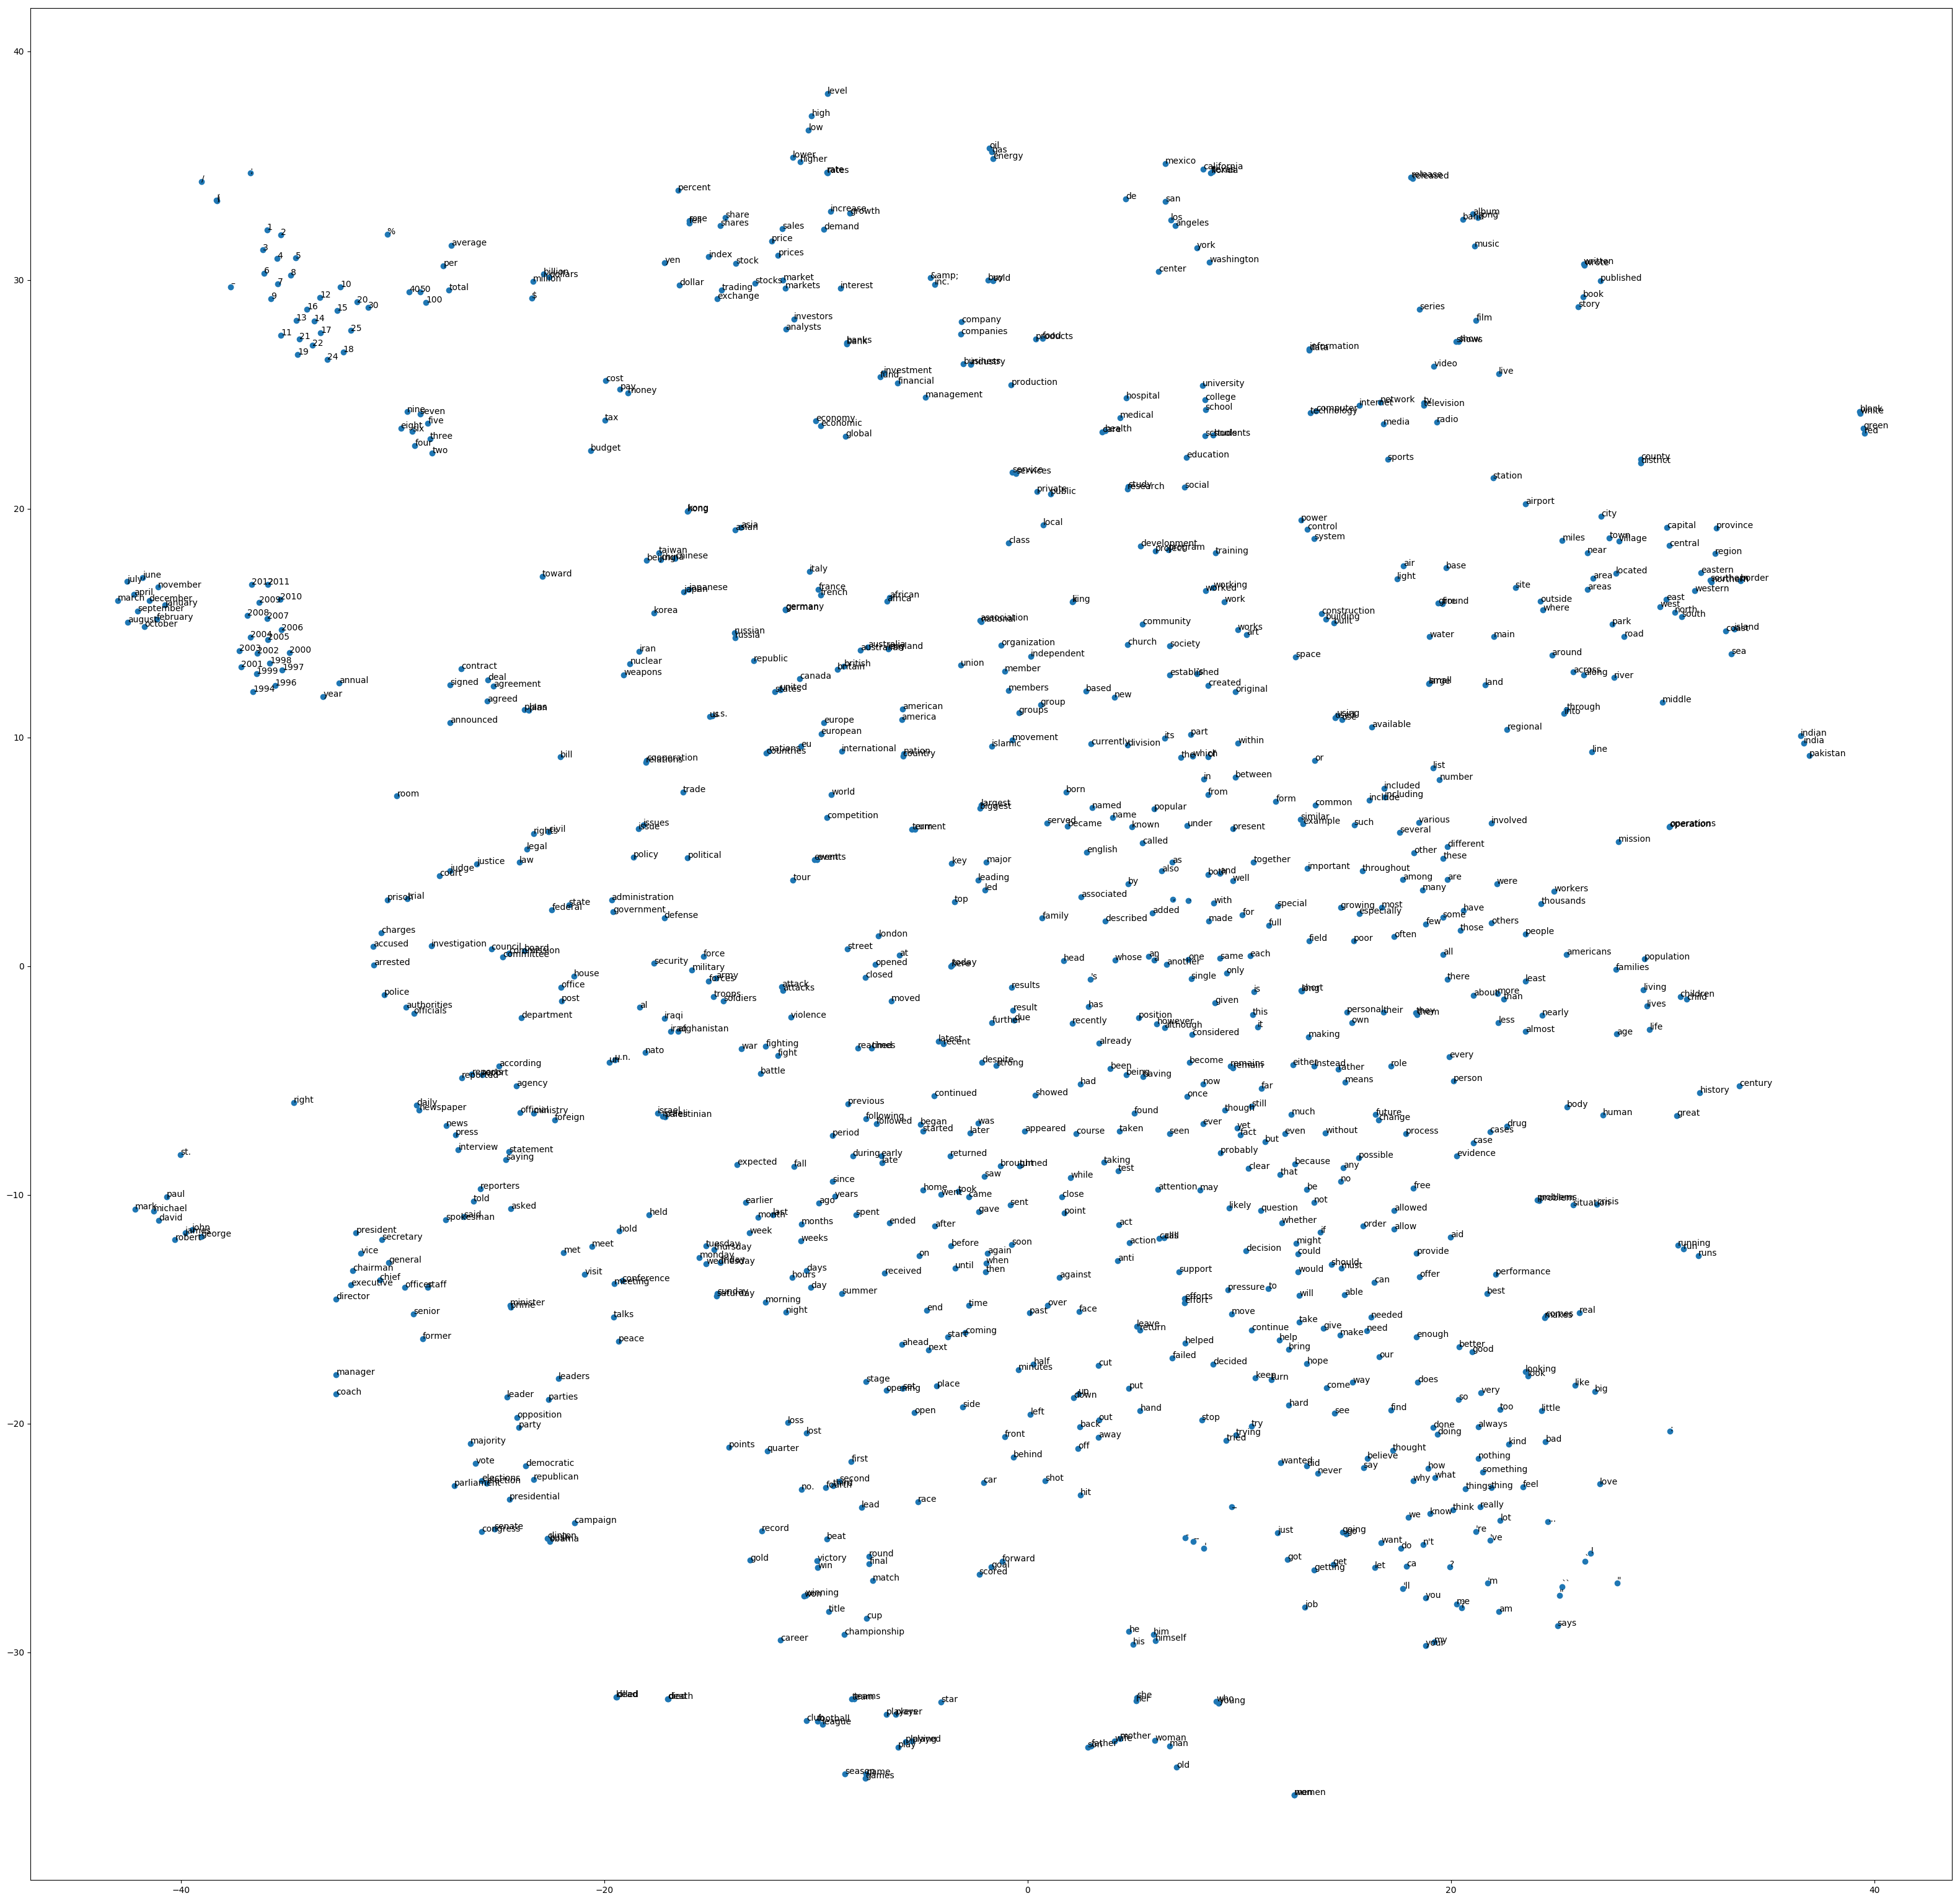

47.851555824279785


In [20]:
start = time.time()
plot_emb_vec("data/glove.6B.50d.txt", 1000)
print(time.time()-start)

#### Plot word embeddings for the sentences

In [39]:
def plot_sim_embedding(actual, generated, desc):
    from gensim.models import Word2Vec    
    from sklearn.decomposition import PCA
    from matplotlib import pyplot
    # define training data
    sentences = [actual, generated, desc]
    # train model
    model = Word2Vec(sentences, min_count=1)
    # fit a 2d PCA model to the vectors
    X = model[model.wv.vocab]
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    # create a scatter plot of the projection
    pyplot.figure(figsize=(20, 20), dpi=100)
    pyplot.scatter(result[:, 0], result[:, 1])
    words = list(model.wv.vocab)
    for i, word in enumerate(words):
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
    pyplot.show()

### Demo cases

#### Test for random article not in original dataset - Demo case

Actual: the eight parts of speech
Generated: nouns place object subject letter common different roles
Preds time: 0.01328277587890625
Word Mover Distance: 1.2602345725155473
WM Distance Time: 17.25145721435547


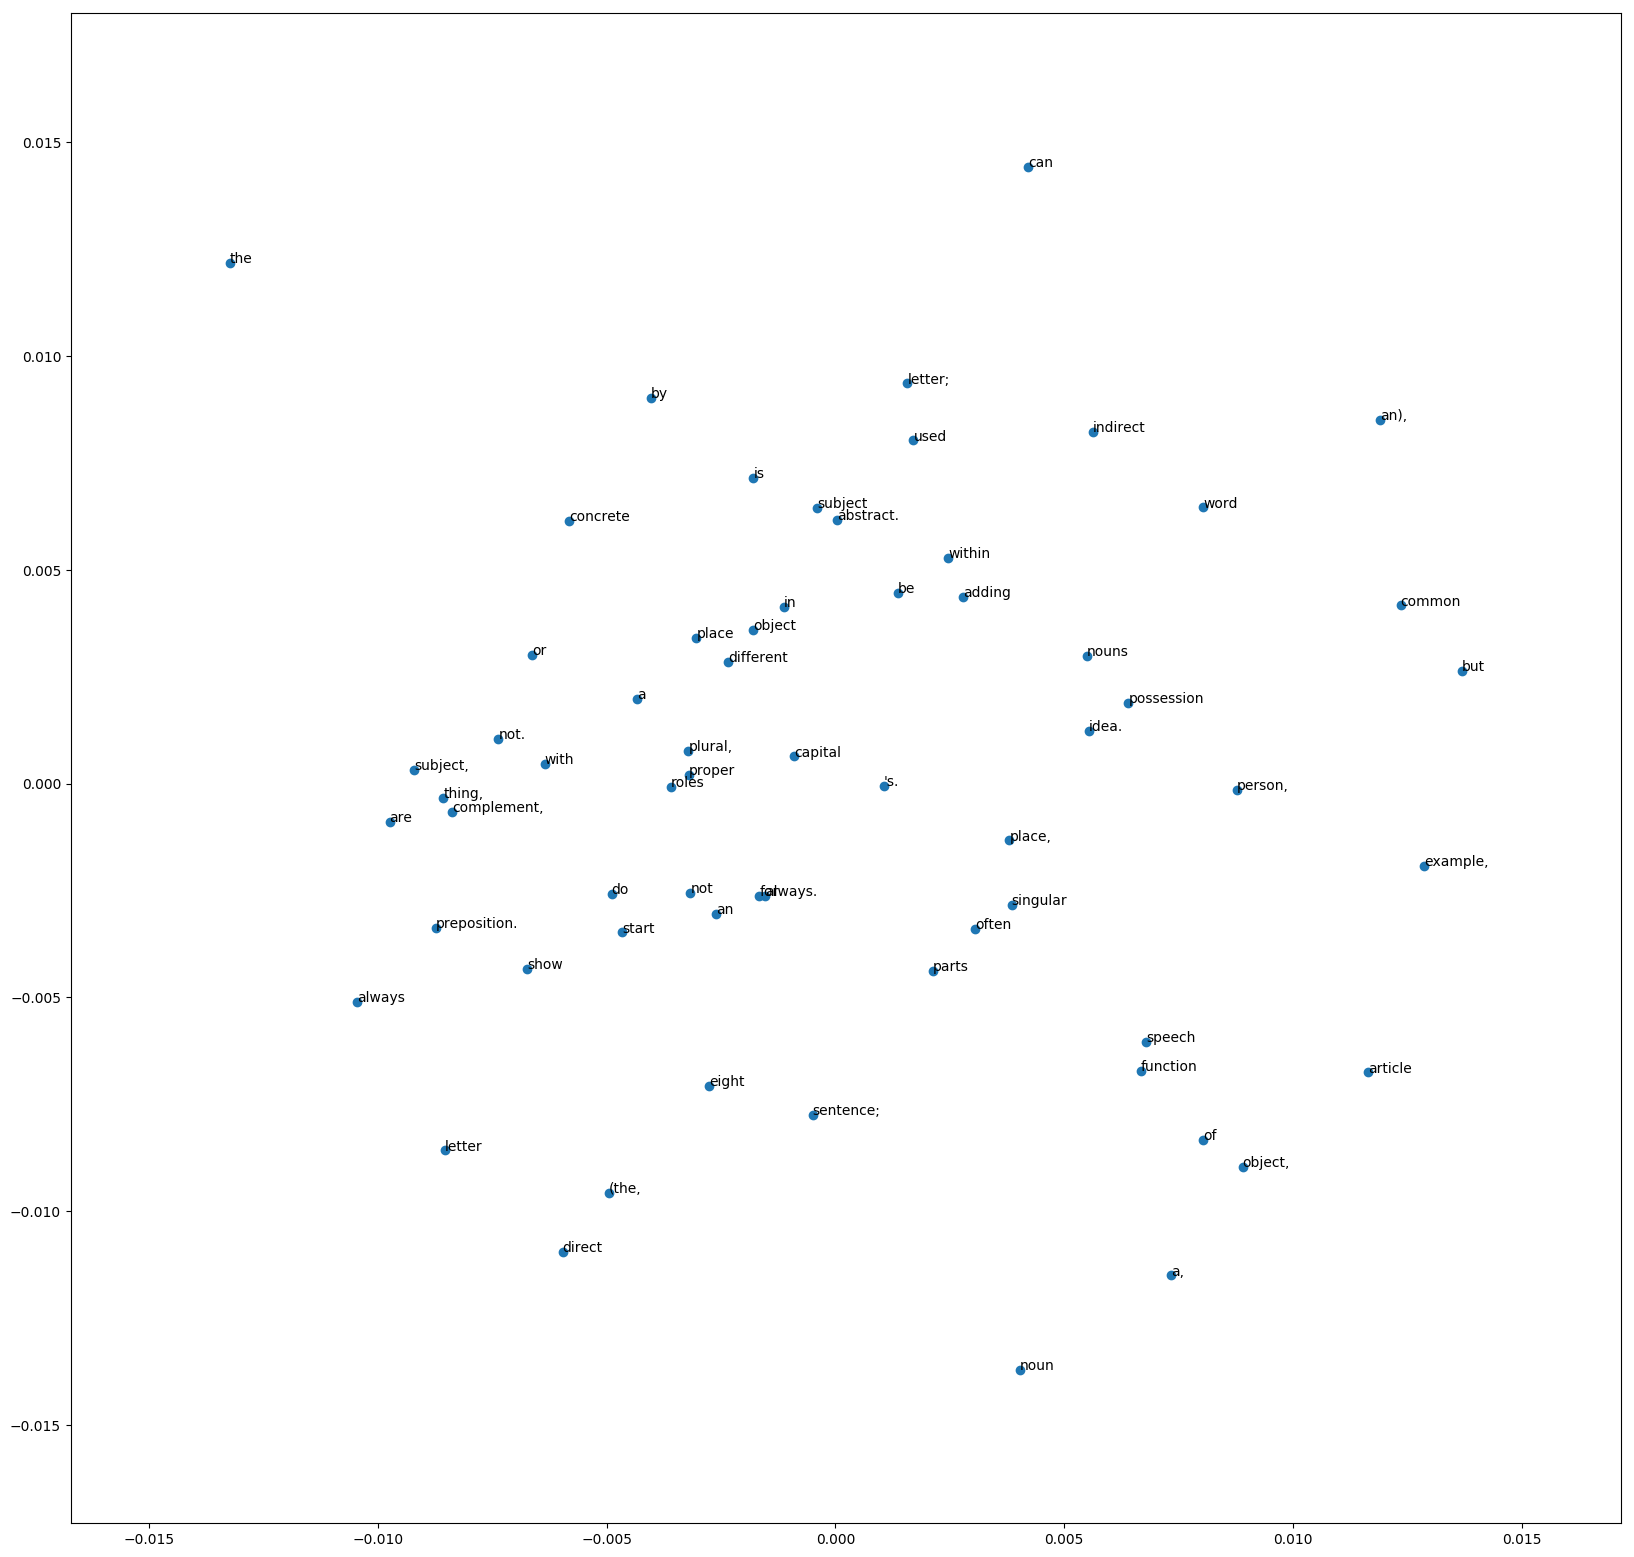

Plot time: 1.2608070373535156


In [40]:
import time
start = time.time()
head = "THE EIGHT PARTS OF SPEECH"
desc = "A noun is a word for a person, place, thing, or idea. Nouns are often used with an article (the, a, an), but not always. Proper nouns always start with a capital letter; common nouns do not. Nouns can be singular or plural, concrete or abstract. Nouns show possession by adding 's. Nouns can function in different roles within a sentence; for example, a noun can be a subject, direct object, indirect object, subject complement, or object of a preposition."
preds = generate_test_preds(live_demo=True, head=head, desc=desc)
print("Actual:", preds[0][1])
print("Generated:", preds[0][2])
print("Preds time:",time.time()-start)
start = time.time()
print("Word Mover Distance:", calc_wm_distance(preds[0][1].split(" "), preds[0][2].split(" ")))
print("WM Distance Time:",time.time()-start)
start = time.time()
plot_sim_embedding(preds[0][1].split(" "), preds[0][2].split(" "),desc.lower().split(" "))
print("Plot time:",time.time()-start)

In [48]:
import pandas as pd
df_test = pd.read_csv("data/preds/model2_preds_all.csv")
FN0 = 'bodies'
with open('data/%s.pkl'%FN0, 'rb') as fp:
    bodies = pickle.load(fp)

Actual: lyft riders will be able to hail a semi-autonomous car by the end of 2017
Generated: autonomous lyft drives cruise company software san anytime tangible raised nearly
Word Mover Distance: 1.30295313251


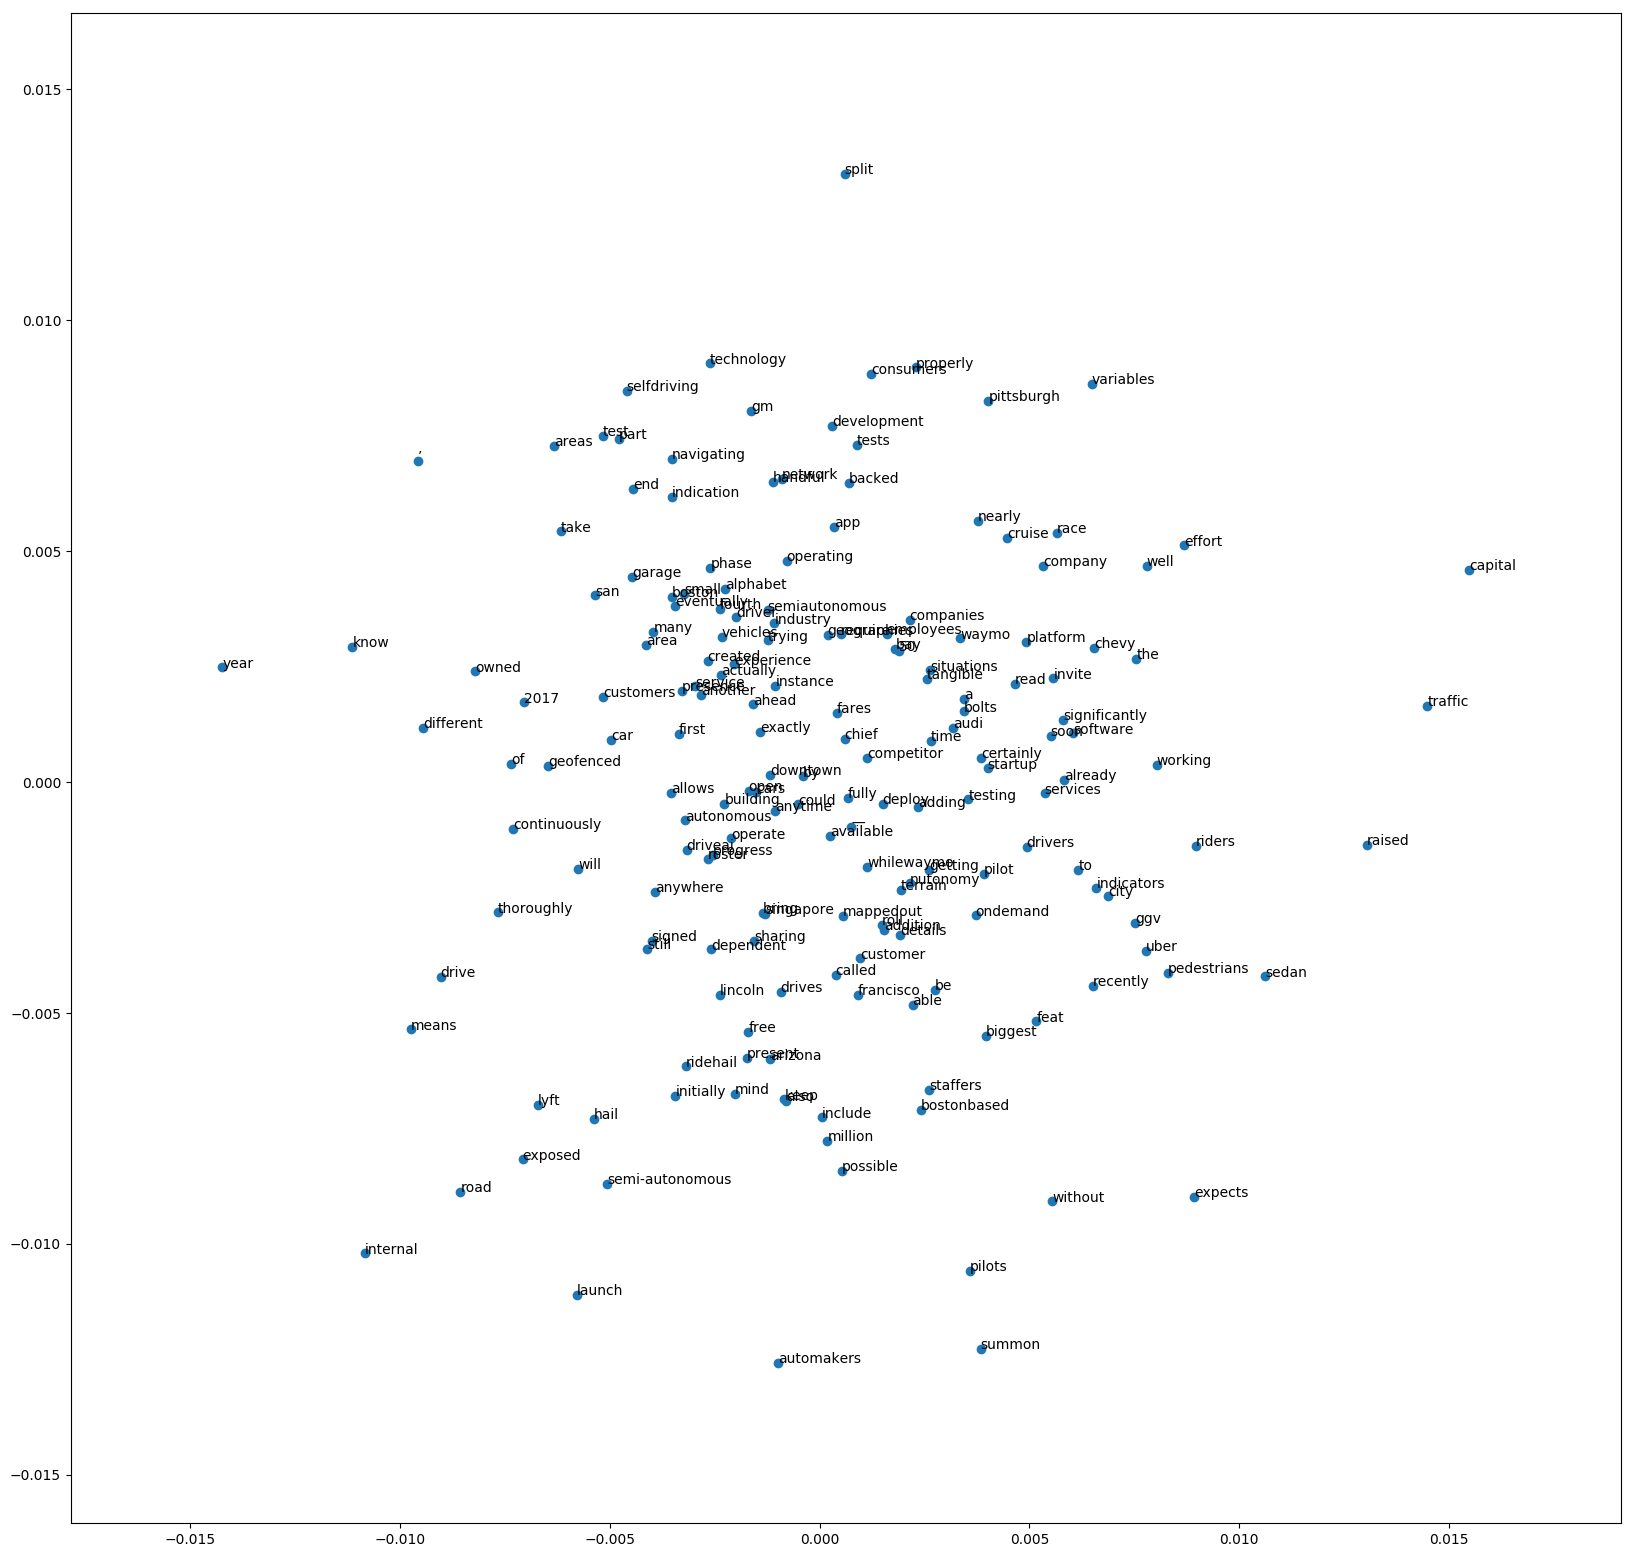

Plot time: 1.6633551120758057


In [51]:
print("Actual:", df_test.loc[0][2])
print("Generated:", df_test.loc[0][3])
print("Word Mover Distance:", df_test.loc[0][4])
start = time.time()
plot_sim_embedding(df_test.loc[0][2].split(" "), df_test.loc[0][3].split(" "),bodies[0])
print("Plot time:",time.time()-start)